# Classification of sentences

First tests of review classification using the whole review text yielded poor results. We will therefore try to predict spoiler for single sentences. 

In [2]:
#for working in Colab only
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
# import libraries
import json
import gzip
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from collections import defaultdict

In [2]:
#generator to open json.gzip files
# yields single lines
def get_reviews(file):
    '''
    Generator will yield lines of the passed file
    '''
    with gzip.open(file, 'r') as f:
        for l in f:
            yield l
    f.close()

In [6]:
# file path when using colab
training = '/content/gdrive/My Drive/nf_capstone/train_set_text_edit.json.gz'
validation = '/content/gdrive/My Drive/nf_capstone/validation_set_text_edit.json.gz'
test = '/content/gdrive/My Drive/nf_capstone/test_set_text_edit.json.gz'

In [ ]:
# file path when working locally

training = 'train_set_text_edit.json.gz'
validation = 'validation_set_text_edit.json.gz'
test = 'test_set_text_edit.json.gz'

In [7]:
# import spoiler reviews from training set
# features to isolate
features = ['sentence_labels', 'lemmatized']

reviews = get_reviews(training)

feature_dict = defaultdict(list)    

# import only reviews written in english and reviews containing spoilers

for review in tqdm(reviews):
    review_dict = json.loads(review)
    language = review_dict.get('review_language_start')
    spoiler = review_dict.get('has_spoiler')
    
    if language != 'en': 
        continue
    elif language == 'en' and spoiler == 0:
        continue
    else:
        for f in features:
            feature_dict[f].append(review_dict.get(f))
df_spoiler_train = pd.DataFrame.from_dict(feature_dict)

964623it [01:13, 13102.01it/s]


In [167]:
df_spoiler_train.head()

,sentence_labels,lemmatized
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[review originally post step fiction, want reb..."
1,"[0, 1, 1, 0]",[interesting volume learn kira power actually ...
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[actually surprised enjoy book, completely for..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",[ok date comment read book go assume eloisa ja...
4,[1],[good book series partly fantastic element]


In [160]:
# function to isolate sentences and labels from dataframe
# returns a dataframe containing sentences and labels

def isolate_sentence_label(dataframe):
    sentences = []
    for review in tqdm(dataframe['lemmatized']):
        for sentence in review:
            sentences.append(sentence)
    
    labels = []
    for review in tqdm(dataframe['sentence_labels']):
        for label in review:
            labels.append(label)
    
    
    df_sentences = pd.DataFrame({
        'has_spoiler': labels,
        'sentences': sentences
    })
    return df_sentences

In [9]:
# isolate sentences and labels from training set

df_sentences = isolate_sentence_label(df_spoiler_train)

100%|██████████| 58428/58428 [00:00<00:00, 333405.61it/s]


In [10]:
df_sentences.shape

(1385613, 2)

In [11]:
# import libraries for evaluation
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# for preprocessing
from sklearn.model_selection import train_test_split

# for modeling
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier 


In [12]:
# perform initial tests on smaller dataset

random_state = 42

X = df_sentences['sentences'].iloc[:100000]
y = df_sentences['has_spoiler'].iloc[:100000]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15, random_state=random_state)

In [13]:
# store models to be tested in a dictionary 
models = {}

models['SGD'] = SGDClassifier()
models['LinearSVC'] = LinearSVC(random_state=random_state) 
models['LogReg'] = LogisticRegression(n_jobs=-1, random_state=random_state)
models['MultinomialNB'] = MultinomialNB(alpha = 1e-6)
models['Ridge'] = RidgeClassifier(random_state=random_state)
models['D_Tree_CLF'] = DecisionTreeClassifier(random_state=random_state)

In [181]:
# function to test classifiers an different datasets using cross validation
def test_clfs(models, X_train, y_train, cv = 5):
    classifier = []
    recall = []
    precision = []
    roc_auc = []
    f1_macro = []
    fit_time = []
    accuracy = []
    
    for name, clf in models.items():
        scores = cross_validate(clf, X_train, y_train, scoring = ['recall', 'accuracy', 'precision', 'f1_macro', 'roc_auc'], 
                                 cv = cv)
        classifier.append(clf) # or maybe use name
        
        fit_time.append(f"{round(np.mean(scores['fit_time']),3)} +/- {round(np.std(scores['fit_time']),3)}")
        recall.append(f"{round(np.mean(scores['test_recall']),3)} +/- {round(np.std(scores['test_recall']),3)}")
        precision.append(f"{round(np.mean(scores['test_precision']),3)} +/- {round(np.std(scores['test_precision']),3)}")
        roc_auc.append(f"{round(np.mean(scores['test_roc_auc']),3)} +/- {round(np.std(scores['test_roc_auc']),3)}")
        f1_macro.append(f"{round(np.mean(scores['test_f1_macro']),3)} +/- {round(np.std(scores['test_f1_macro']),3)}")
        accuracy.append(f"{round(np.mean(scores['test_accuracy']),3)} +/- {round(np.std(scores['test_accuracy']),3)}")
        
        print(f'Done with {name}')
        
    classification_result = pd.DataFrame({
        'classifier':classifier,
        'fit_time': fit_time,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'roc_auc': roc_auc,
        'f1_macro': f1_macro})
    return classification_result

We will first test Tfidf vectorization.

In [37]:
# innitiate vectorizer using standard settings
vectorizer = TfidfVectorizer()

# fit the transformer
tfidf = vectorizer.fit(X_train)

X_train_vec = tfidf.transform(X_train)

test = test_clfs(models, X_train_vec, y_train)
test

Done with SGD
Done with LinearSVC
Done with LogReg
Done with MultinomialNB
Done with Ridge
Done with D_Tree_CLF


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,"SGDClassifier(alpha=0.0001, average=False, cla...",0.141 +/- 0.008,0.742 +/- 0.001,0.071 +/- 0.004,0.698 +/- 0.026,0.709 +/- 0.002,0.488 +/- 0.003
1,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.414 +/- 0.014,0.743 +/- 0.003,0.298 +/- 0.008,0.541 +/- 0.01,0.706 +/- 0.003,0.611 +/- 0.005
2,"LogisticRegression(C=1.0, class_weight=None, d...",1.397 +/- 0.317,0.752 +/- 0.003,0.202 +/- 0.007,0.622 +/- 0.018,0.728 +/- 0.003,0.577 +/- 0.006
3,"MultinomialNB(alpha=1e-06, class_prior=None, f...",0.017 +/- 0.001,0.741 +/- 0.003,0.251 +/- 0.005,0.54 +/- 0.014,0.671 +/- 0.008,0.591 +/- 0.005
4,"RidgeClassifier(alpha=1.0, class_weight=None, ...",0.207 +/- 0.01,0.749 +/- 0.003,0.265 +/- 0.008,0.573 +/- 0.011,0.712 +/- 0.004,0.603 +/- 0.006
5,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",33.712 +/- 0.662,0.69 +/- 0.003,0.318 +/- 0.006,0.404 +/- 0.007,0.578 +/- 0.003,0.576 +/- 0.004


Given that the spoiler frequency in the sentence dataset is approx. 25%, these results are not very promissing. Test CountVectorizer next.

In [38]:
# innitiate vectorizer using standard settings
vectorizer = CountVectorizer(min_df = 50, stop_words = 'english',ngram_range=(1,2) )

# fit the transformer
cvec = vectorizer.fit(X_train)

X_train_vec = cvec.transform(X_train)

test = test_clfs(models, X_train_vec, y_train)
test

Done with SGD


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Done with LinearSVC
Done with LogReg
Done with MultinomialNB
Done with Ridge
Done with D_Tree_CLF


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,"SGDClassifier(alpha=0.0001, average=False, cla...",0.155 +/- 0.01,0.743 +/- 0.003,0.122 +/- 0.005,0.619 +/- 0.024,0.677 +/- 0.002,0.525 +/- 0.005
1,"LinearSVC(C=1.0, class_weight=None, dual=True,...",7.279 +/- 0.157,0.745 +/- 0.003,0.182 +/- 0.006,0.587 +/- 0.014,0.698 +/- 0.003,0.561 +/- 0.005
2,"LogisticRegression(C=1.0, class_weight=None, d...",0.935 +/- 0.013,0.745 +/- 0.003,0.195 +/- 0.009,0.579 +/- 0.014,0.7 +/- 0.004,0.568 +/- 0.007
3,"MultinomialNB(alpha=1e-06, class_prior=None, f...",0.015 +/- 0.0,0.735 +/- 0.004,0.322 +/- 0.009,0.511 +/- 0.01,0.706 +/- 0.004,0.612 +/- 0.006
4,"RidgeClassifier(alpha=1.0, class_weight=None, ...",0.131 +/- 0.002,0.745 +/- 0.003,0.169 +/- 0.009,0.593 +/- 0.017,0.697 +/- 0.004,0.555 +/- 0.007
5,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",7.743 +/- 0.168,0.68 +/- 0.003,0.293 +/- 0.01,0.378 +/- 0.007,0.589 +/- 0.008,0.56 +/- 0.004


From all the tested conditions, Multinomial Base gives the best results. However, a recall of 0.322 is not satisfying. We will next try oversampling strategies to account or the class imbalance. 

In [14]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state = 42, n_jobs = -1)

In [45]:
# oversample vectorized training data
X_res, y_res = sm.fit_resample(X_train_vec, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [46]:
# test oversampled data with different classifiers
test = test_clfs(models, X_res, y_res)
test

Done with SGD


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done with LinearSVC


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done with LogReg
Done with MultinomialNB
Done with Ridge
Done with D_Tree_CLF


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,"SGDClassifier(alpha=0.0001, average=False, cla...",0.201 +/- 0.018,0.694 +/- 0.076,0.81 +/- 0.195,0.65 +/- 0.037,0.76 +/- 0.101,0.686 +/- 0.071
1,"LinearSVC(C=1.0, class_weight=None, dual=True,...",12.696 +/- 0.504,0.704 +/- 0.078,0.806 +/- 0.183,0.662 +/- 0.041,0.755 +/- 0.087,0.698 +/- 0.075
2,"LogisticRegression(C=1.0, class_weight=None, d...",1.419 +/- 0.265,0.706 +/- 0.081,0.792 +/- 0.19,0.668 +/- 0.042,0.756 +/- 0.087,0.701 +/- 0.078
3,"MultinomialNB(alpha=1e-06, class_prior=None, f...",0.021 +/- 0.003,0.652 +/- 0.023,0.661 +/- 0.083,0.649 +/- 0.006,0.697 +/- 0.008,0.651 +/- 0.022
4,"RidgeClassifier(alpha=1.0, class_weight=None, ...",0.155 +/- 0.01,0.702 +/- 0.079,0.816 +/- 0.176,0.657 +/- 0.043,0.753 +/- 0.09,0.696 +/- 0.075
5,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",9.534 +/- 1.214,0.699 +/- 0.083,0.817 +/- 0.172,0.654 +/- 0.048,0.709 +/- 0.072,0.694 +/- 0.079


Using cross-validation with oversampling, the results on the trainig set are much better than the results obtained with the imbalanced data set. Espacially the Ridge classifier, SGD, DecissionTreeClassifier and Linear SVC show promissing results (recall and precision). We will continue with the SGD and Ridge classifiers as they are the fastest.

In [180]:
# for full dataset
X = df_sentences['sentences']
y = df_sentences['has_spoiler']

# oversample the full training dataset
vectorizer = CountVectorizer(min_df = 50, stop_words = 'english',ngram_range=(1,2) )
cvec = vectorizer.fit(X)
X_vec = cvec.transform(X)
X_res, y_res = sm.fit_resample(X_vec, y)




KeyboardInterrupt: 

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [20]:
# set up pipelines for training
# Note taht imblearn also overs pipelines but we had problems using this implementation

MNB_pipeline = Pipeline([
    ('vec', CountVectorizer(min_df = 100, stop_words = 'english', ngram_range = (1,2))),
    ('KBest', SelectKBest(chi2, 10000)),
    ('MNB', MultinomialNB())], verbose = True
)
Ridge_smote_pipeline = Pipeline([
    
    ('KBest', SelectKBest(chi2, 10000)),
    ('Ridge',RidgeClassifier(random_state=random_state)),], verbose = True
)
SGD_smote_pipeline= Pipeline([
    
    ('KBest', SelectKBest(chi2, 10000)),
    ('SGD',SGDClassifier(random_state=random_state))], verbose = True
)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass k=10000 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [179]:
#fit classifier/pipelines
MNB_pipeline.fit(X,y)
print('Done with MNB pipeline')
Ridge_smote_pipeline.fit(X_res, y_res)
print('Done with Ridge pipeline')
SGD_smote_pipeline.fit(X_res, y_res)
print('Done with SGD')

ValueError: max_df corresponds to < documents than min_df

In [31]:
# predict training data
prediction = MNB_pipeline.predict(X)
prediction2 = Ridge_smote_pipeline.predict(X_vec)
prediction3 = SGD_smote_pipeline.predict(X_vec)

In [32]:
# analyse predictions of training data with classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
# test multinomial Bayes on trainings data
confusion_matrix(y, prediction)

array([[862963, 154127],
       [212398, 156125]])

In [34]:
print(classification_report(y, prediction))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82   1017090
           1       0.50      0.42      0.46    368523

    accuracy                           0.74   1385613
   macro avg       0.65      0.64      0.64   1385613
weighted avg       0.72      0.74      0.73   1385613



In [35]:
# test ridge classifier on trainings data 
confusion_matrix(y, prediction2)

array([[619115, 397975],
       [127567, 240956]])

In [36]:
print(classification_report(y, prediction2))

              precision    recall  f1-score   support

           0       0.83      0.61      0.70   1017090
           1       0.38      0.65      0.48    368523

    accuracy                           0.62   1385613
   macro avg       0.60      0.63      0.59   1385613
weighted avg       0.71      0.62      0.64   1385613



In [37]:
# test SGD classifier 
confusion_matrix(y, prediction3)

array([[591413, 425677],
       [125370, 243153]])

In [38]:
print(classification_report(y, prediction3))

              precision    recall  f1-score   support

           0       0.83      0.58      0.68   1017090
           1       0.36      0.66      0.47    368523

    accuracy                           0.60   1385613
   macro avg       0.59      0.62      0.58   1385613
weighted avg       0.70      0.60      0.63   1385613



We note that the precission of predictions for the whole dataset is much smaller/worse than on the smaller test dataset-suggesting a higher false positive rate. As the rrecall is still much better than the spoiler frequency we will proceed anyways. 

In [41]:
# compare results of different predictors
sum_prediction=np.add(prediction, prediction2, prediction3)
np.unique(sum_prediction, return_counts= True)

(array([0, 1, 2]), array([653460, 515123, 217030]))

This suggests that not a single sentence is classified as a spoiler by all three models.  
The classifiers using oversampling have the highest recall for spoiler sentences but also lower recall for safe sentences, suggesting a high false positive rate.

#### Test models on validation set

In [145]:
# import spoiler reviews from validation set
# features to isolate
features = ['sentence_labels', 'lemmatized']

reviews = get_reviews(validation)

feature_dict = defaultdict(list)    

# import only reviews written in english and reviews containing spoilers

for review in tqdm(reviews):
    review_dict = json.loads(review)
    language = review_dict.get('review_language_start')
    spoiler = review_dict.get('has_spoiler')
    
    if language != 'en': 
        continue
    elif language == 'en' and spoiler == 0:
        continue
    else:
        for f in features:
            feature_dict[f].append(review_dict.get(f))
df_spoiler_val = pd.DataFrame.from_dict(feature_dict)

275606it [00:42, 6557.02it/s]


In [161]:
df_val_sentences = isolate_sentence_label(df_spoiler_val)

100%|██████████| 16521/16521 [00:00<00:00, 336571.90it/s]


In [178]:
# transform test data
X_val_vec = cvec.transform(df_val_sentences['sentences'])
#predict test data
predict_val = MNB_pipeline.predict(df_val_sentences['sentences'])
predict_val2 = Ridge_smote.predict(X_val_vec)
predict_val2 = SGD_SMOTE.predict(X_val_vec)

NameError: name 'Ridge_smote' is not defined

In [37]:
# confusion matrix for MNB (no oversampling)
confusion_matrix(df_val_sentences['has_spoiler'], predict_val)

array([[241181,  42644],
       [ 61961,  41703]])

In [41]:
# classification report for MNB (no oversampling)
print(classification_report(df_val_sentences['has_spoiler'], predict_val))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82    283825
           1       0.49      0.40      0.44    103664

    accuracy                           0.73    387489
   macro avg       0.65      0.63      0.63    387489
weighted avg       0.72      0.73      0.72    387489



In [42]:
# confusion matrix for Ridge classifier (with oversampling)
confusion_matrix(df_val_sentences['has_spoiler'], predict_val2)

array([[163772, 120053],
       [ 35784,  67880]])

In [177]:
# classification report for Ridge classifier (with oversampling)
print(classification_report(df_val_sentences['has_spoiler'], predict_val2))

NameError: name 'predict_val2' is not defined

The Ridge classifier is over-fitted to the training data as the recall is 20% highe on the trainingsdata compared to the unknown data. The SGD classifier trained on the oversampled data still has a recall of 65% for spoielr sentences, but with a precission of 0.36 and a recall for safe sentences of 0.58, many sentences are falsly classified as spoiler sentences even though the don't contain a spoiler. 

In [ ]:
# optimize the KNN using grid_search

In [ ]:
# parameters to optimize in pipeline 
from sklearn.feature_selection import f_classif, mutual_info_classif

param_grid = {
    'vec__ngram_range':[(1,1),(1,2), (2,2),(1,3), (3,3)],
    #'KBest__score_func':[f_classif, chi2, mutual_info_classif],
    'KBest__k': [1000,5000,10000],
    'MNB__alpha': [1, 1e-3, 1e-6, 1e-9]
  }


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

grid_MNB = GridSearchCV(pipeline, param_grid = param_grid, cv = 3, scoring = 'recall', verbose = 7)
grid_MNB.fit(X,y)



Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 1) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 1), score=0.302, total=  12.5s
[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 1), score=0.298, total=  12.6s
[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 1) ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.2s remaining:    0.0s


[Pipeline] ............... (step 1 of 3) Processing vec, total=   8.2s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 1), score=0.300, total=  13.0s
[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 2) ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.2s remaining:    0.0s


[Pipeline] ............... (step 1 of 3) Processing vec, total=  32.5s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 2), score=0.320, total=  39.9s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 2) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=  30.3s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 2), score=0.313, total=  37.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s


[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 2) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.7s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(1, 2), score=0.317, total=  37.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(2, 2) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.1s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(2, 2), score=0.066, total=  30.6s
[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(2, 2) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.5s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(2, 2), score=0.066, total=  31.0s
[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(2, 2) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.1s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.2s
[Pipeline] ............... (step 3 of 3) Proc

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(3, 3) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.3s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(3, 3), score=nan, total=  34.5s
[CV] KBest__k=1000, MNB__alpha=1, vec__ngram_range=(3, 3) ............


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  33.9s
[CV]  KBest__k=1000, MNB__alpha=1, vec__ngram_range=(3, 3), score=nan, total=  34.1s
[CV] KBest__k=1000, MNB__alpha=0.001, vec__ngram_range=(1, 1) ........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=0.001, vec__ngram_range=(1, 1), score=0.303, total=  12.5s
[CV] KBest__k=1000, MNB__alpha=0.001, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=0.001, vec__ngram_range=(1, 1), score=0.298, total=  12.5s
[CV] KBest__k=1000, MNB__alpha=0.001, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=0.001

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  33.7s
[CV]  KBest__k=1000, MNB__alpha=0.001, vec__ngram_range=(3, 3), score=nan, total=  33.8s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=1000, MNB__alpha=0.001, vec__ngram_range=(3, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  33.7s
[CV]  KBest__k=1000, MNB__alpha=0.001, vec__ngram_range=(3, 3), score=nan, total=  33.8s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=1000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1e-06, vec__ngram_range=(1, 1), score=0.303, total=  12.4s
[CV] KBest__k=1000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1e-06, vec__ngram_range=(1, 1), score=0.298, total=  12.4s
[CV] KBest__k=1000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   8.3s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  35.1s
[CV]  KBest__k=1000, MNB__alpha=1e-06, vec__ngram_range=(3, 3), score=nan, total=  35.2s
[CV] KBest__k=1000, MNB__alpha=1e-06, vec__ngram_range=(3, 3) ........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  36.2s
[CV]  KBest__k=1000, MNB__alpha=1e-06, vec__ngram_range=(3, 3), score=nan, total=  36.3s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   8.4s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(1, 1), score=0.303, total=  13.2s
[CV] KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(1, 1), score=0.298, total=  12.5s
[CV] KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.9s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(3, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.0s
[CV]  KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(3, 3), score=nan, total=  34.1s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(3, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.1s
[CV]  KBest__k=1000, MNB__alpha=1e-09, vec__ngram_range=(3, 3), score=nan, total=  34.2s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 1000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 1) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 1), score=0.348, total=  12.5s
[CV] KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 1) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 1), score=0.342, total=  12.5s
[CV] KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 1) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Proc

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2330; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  27.7s
[CV]  KBest__k=5000, MNB__alpha=1, vec__ngram_range=(2, 2), score=nan, total=  27.8s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2346; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1, vec__ngram_range=(2, 2) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.8s
[CV]  KBest__k=5000, MNB__alpha=1, vec__ngram_range=(2, 2), score=nan, total=  25.9s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2363; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 3) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.1min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 3), score=0.401, total= 1.2min
[CV] KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 3) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.1min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 3), score=0.394, total= 1.2min
[CV] KBest__k=5000, MNB__alpha=1, vec__ngram_range=(1, 3) ............
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.1min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Proc

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  35.9s
[CV]  KBest__k=5000, MNB__alpha=1, vec__ngram_range=(3, 3), score=nan, total=  36.0s
[CV] KBest__k=5000, MNB__alpha=1, vec__ngram_range=(3, 3) ............


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  35.8s
[CV]  KBest__k=5000, MNB__alpha=1, vec__ngram_range=(3, 3), score=nan, total=  35.9s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 1), score=0.349, total=  12.5s
[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 1), score=0.342, total=  12.6s
[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2330; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(2, 2) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.4s
[CV]  KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(2, 2), score=nan, total=  25.5s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2346; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(2, 2) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.6s
[CV]  KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(2, 2), score=nan, total=  25.7s
[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 3) ........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2363; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.1min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 3), score=0.402, total= 1.3min
[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 3), score=0.395, total= 1.2min
[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(1, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=0.001

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(3, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.4s
[CV]  KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(3, 3), score=nan, total=  34.5s
[CV] KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(3, 3) ........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  33.8s
[CV]  KBest__k=5000, MNB__alpha=0.001, vec__ngram_range=(3, 3), score=nan, total=  33.9s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 1), score=0.349, total=  12.4s
[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 1), score=0.342, total=  12.4s
[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2330; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.1s
[CV]  KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(2, 2), score=nan, total=  25.2s
[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(2, 2) ........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2346; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.5s
[CV]  KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(2, 2), score=nan, total=  25.6s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2363; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 3), score=0.402, total= 1.2min
[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.1min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 3), score=0.395, total= 1.3min
[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(1, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(3, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  33.7s
[CV]  KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(3, 3), score=nan, total=  33.8s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(3, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.4s
[CV]  KBest__k=5000, MNB__alpha=1e-06, vec__ngram_range=(3, 3), score=nan, total=  34.6s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 1), score=0.349, total=  12.3s
[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 1), score=0.342, total=  12.4s
[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.9s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2330; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(2, 2) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.5s
[CV]  KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(2, 2), score=nan, total=  25.6s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2346; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(2, 2) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.5s
[CV]  KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(2, 2), score=nan, total=  25.6s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2363; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s
[CV]  KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 3), score=0.402, total= 1.2min
[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.1min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.6s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.5s
[CV]  KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 3), score=0.395, total= 1.2min
[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(1, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.1min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.3s
[Pipeline] ............... (step 3 of

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(3, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.9s
[CV]  KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(3, 3), score=nan, total=  35.0s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(3, 3) ........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  35.1s
[CV]  KBest__k=5000, MNB__alpha=1e-09, vec__ngram_range=(3, 3), score=nan, total=  35.2s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 5000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 1) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 1), score=nan, total=   7.9s
[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 1) ...........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5236; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 1), score=nan, total=   7.9s
[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 1) ...........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5241; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 1), score=nan, total=   7.9s
[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 2) ...........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5239; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  30.1s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 2), score=nan, total=  30.2s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7566; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 2) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  30.8s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 2), score=nan, total=  30.9s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7587; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 2) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  30.7s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 2), score=nan, total=  30.8s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7602; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(2, 2) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.8s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(2, 2), score=nan, total=  25.9s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2330; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(2, 2) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  26.1s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(2, 2), score=nan, total=  26.2s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2346; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(2, 2) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.9s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(2, 2), score=nan, total=  26.0s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2363; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 3) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7665; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 3) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7690; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 3) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7710; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(3, 3) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  38.2s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(3, 3), score=nan, total=  38.3s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(3, 3) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  35.1s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(3, 3), score=nan, total=  35.2s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1, vec__ngram_range=(3, 3) ...........
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.3s
[CV]  KBest__k=10000, MNB__alpha=1, vec__ngram_range=(3, 3), score=nan, total=  34.5s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 1) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 1), score=nan, total=   7.9s
[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 1) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5236; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   8.1s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 1), score=nan, total=   8.2s
[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 1) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5241; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 1), score=nan, total=   7.8s
[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 2) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5239; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.8s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 2), score=nan, total=  29.9s
[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 2) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7566; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.9s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 2), score=nan, total=  30.0s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7587; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.5s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 2), score=nan, total=  29.6s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7602; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(2, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.3s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(2, 2), score=nan, total=  25.4s
[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(2, 2) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2330; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.6s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(2, 2), score=nan, total=  25.7s
[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(2, 2) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2346; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.6s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(2, 2), score=nan, total=  25.7s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2363; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.1min
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 3), score=nan, total= 1.1min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7665; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 3), score=nan, total= 1.0min
[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 3) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7690; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(1, 3), score=nan, total= 1.0min
[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(3, 3) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7710; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.2s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(3, 3), score=nan, total=  34.3s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(3, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.3s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(3, 3), score=nan, total=  34.4s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(3, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.0s
[CV]  KBest__k=10000, MNB__alpha=0.001, vec__ngram_range=(3, 3), score=nan, total=  34.2s
[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 1), score=nan, total=   7.9s
[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5236; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 1), score=nan, total=   7.8s
[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 1) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5241; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.7s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 1), score=nan, total=   7.8s
[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 2) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5239; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  33.2s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 2), score=nan, total=  33.3s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7566; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.6s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 2), score=nan, total=  29.7s
[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 2) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7587; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.8s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 2), score=nan, total=  29.9s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7602; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(2, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.2s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(2, 2), score=nan, total=  25.4s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2330; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(2, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.3s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(2, 2), score=nan, total=  25.5s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2346; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(2, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.2s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(2, 2), score=nan, total=  25.4s
[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 3) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2363; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7665; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7690; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7710; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(3, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.2s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(3, 3), score=nan, total=  34.4s
[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(3, 3) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.4s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(3, 3), score=nan, total=  34.5s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(3, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.2s
[CV]  KBest__k=10000, MNB__alpha=1e-06, vec__ngram_range=(3, 3), score=nan, total=  34.3s
[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 1), score=nan, total=   7.9s
[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5236; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 1), score=nan, total=   7.9s
[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 1) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5241; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=   7.8s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 1), score=nan, total=   7.9s
[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 2) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 5239; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  30.0s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 2), score=nan, total=  30.1s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7566; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.6s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 2), score=nan, total=  29.7s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7587; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.5s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 2), score=nan, total=  29.6s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7602; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(2, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.2s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(2, 2), score=nan, total=  25.3s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2330; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(2, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  25.6s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(2, 2), score=nan, total=  25.7s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2346; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(2, 2) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  29.2s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(2, 2), score=nan, total=  29.3s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 2363; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7665; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7690; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.0min
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(1, 3), score=nan, total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 7710; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(3, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.5s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(3, 3), score=nan, total=  34.6s
[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(3, 3) .......


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 99; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.5s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(3, 3), score=nan, total=  34.6s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 103; got 10000. Use k='all' to return all features.

  FitFailedWarning)


[CV] KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(3, 3) .......
[Pipeline] ............... (step 1 of 3) Processing vec, total=  34.6s
[CV]  KBest__k=10000, MNB__alpha=1e-09, vec__ngram_range=(3, 3), score=nan, total=  34.7s


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 108; got 10000. Use k='all' to return all features.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 107.8min finished


[Pipeline] ............... (step 1 of 3) Processing vec, total= 1.6min
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.5s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.3s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=100,
                                                        ngram_range=(1, 2),
                                                        pre

In [ ]:
print('Best score:\n{:.2f}'.format(grid_MNB.best_score_))
print('Best parameters:\n{}'.format(grid_MNB.best_params_))

Best score:
0.40
Best parameters:
{'KBest__k': 5000, 'MNB__alpha': 0.001, 'vec__ngram_range': (1, 3)}


In [ ]:
best_model = grid_MNB.best_estimator_

In [42]:
MNB_pipeline = Pipeline([
    ('vec', CountVectorizer(min_df = 100, stop_words = 'english', ngram_range = (1,3))),
    ('KBest', SelectKBest(chi2, k = 5000)),
    ('MNB', MultinomialNB(alpha = 0.001))], verbose = True
)

In [43]:
# fit again with best parameters
X = df_sentences['sentences']
y = df_sentences['has_spoiler']

MNB_pipeline.fit(X,y)

[Pipeline] ............... (step 1 of 3) Processing vec, total=  43.5s
[Pipeline] ............. (step 2 of 3) Processing KBest, total=   0.4s
[Pipeline] ............... (step 3 of 3) Processing MNB, total=   0.2s


Pipeline(steps=[('vec',
                 CountVectorizer(min_df=100, ngram_range=(1, 3),
                                 stop_words='english')),
                ('KBest',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x7fe389030430>)),
                ('MNB', MultinomialNB(alpha=0.001))],
         verbose=True)

The recall and hyper parameters of the best grid search model are very similar to the randomly chosen parameters. 

In [ ]:
## Also add a classifier for whole reviews and not only sentences
## this work was manly pushed by Julia Schaefer/

In [44]:
# load train data
features = ['has_spoiler', 'sentence_labels', 'lemmatized']

reviews = get_reviews(training)

feature_dict = defaultdict(list)    

# import only reviews written in english and reviews containing spoilers

for review in tqdm(reviews):
    review_dict = json.loads(review)
    language = review_dict.get('review_language_start')

    
    if language != 'en': 
        continue
    else:
        for f in features:
            feature_dict[f].append(review_dict.get(f))
df_train_reviews = pd.DataFrame.from_dict(feature_dict)

964623it [01:41, 9528.69it/s] 


In [45]:
# down sample data to account for imbalance data

df_safe = df_train_reviews[df_train_reviews['has_spoiler']== False]
df_spoiler = df_train_reviews[df_train_reviews['has_spoiler']== True]

In [46]:
# number of samples in minority class
min_size = df_spoiler.shape[0]
df_safe = df_safe.sample(min_size, random_state = 42)


In [47]:
# concatenate and shuffle both dataframe
df_train_reviews_sample = pd.concat([df_spoiler,df_safe ])
# check sampling
np.unique(df_train_reviews_sample['has_spoiler'], return_counts = True)

(array([False,  True]), array([58428, 58428]))

In [51]:
#Pipeline
pipe_sgd = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', ngram_range = (1,2), min_df = 100)),
                 ('sgd', SGDClassifier(random_state = 42, penalty = 'l2', shuffle = True, n_jobs = -1, max_iter = 1000, 
                                       loss = 'hinge', class_weight = {0: 0.4, 1: .6}, alpha = .0001))], verbose = True)

In [52]:
# fit sgd model
x_review = df_train_reviews_sample['lemmatized'].apply(lambda x: ' '.join(x))
pipe_sgd.fit(x_review,df_train_reviews_sample['has_spoiler'])

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=  36.7s
[Pipeline] ............... (step 2 of 2) Processing sgd, total=   0.5s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=100, ngram_range=(1, 2),
                                 stop_words='english')),
                ('sgd',
                 SGDClassifier(class_weight={0: 0.4, 1: 0.6}, n_jobs=-1,
                               random_state=42))],
         verbose=True)

## Test single classifier on whole reviews


In [ ]:
# load train data
features = ['has_spoiler', 'sentence_labels', 'lemmatized', 'best_genre']

reviews = get_reviews(training)

feature_dict = defaultdict(list)    

# import only reviews written in english and reviews containing spoilers

for review in tqdm(reviews):
    review_dict = json.loads(review)
    language = review_dict.get('review_language_start')

    
    if language != 'en': 
        continue
    else:
        for f in features:
            feature_dict[f].append(review_dict.get(f))
df_train = pd.DataFrame.from_dict(feature_dict)

In [ ]:
# test predictions on whole training set 
# go through every review and get probability for every sentence
# then get max probability

In [53]:
# predict spoiler for every sentence in review
# get the max probability

proba_mnb_sentence = []
proba_SGD_SMOTE = []
proba_Ridge_smote = []
proba_SGD_review = []

spoiler_predicted = []
for review in df_train_reviews['lemmatized']:
    proba_mnb_sentence.append(np.max(MNB_pipeline.predict_proba(review).T[1]))
  
  #vectorize sentences
    c_vec_matrix = cvec.transform(review)
    proba_SGD_SMOTE.append(np.max(SGD_smote_pipeline.decision_function(c_vec_matrix)))
    proba_Ridge_smote.append(np.max(Ridge_smote_pipeline.decision_function(c_vec_matrix)))

#for prediction of review probability

X_train = df_train_reviews['lemmatized'].apply(lambda x: ' '.join(x))
proba_SGD_review = pipe_sgd.decision_function(X_train)

In [54]:
df_probabilities = pd.DataFrame({
    'mnb_sentence_max': proba_mnb_sentence,
    'SGD_sentence_max' : proba_SGD_SMOTE,
    'Ridge_sentence_max' : proba_Ridge_smote,
    'SGD_review' : proba_SGD_review,
    'has_spoiler' : df_train_reviews['has_spoiler']
})


In [97]:
df_probabilities.to_json('training_clfs_for_stacking.json', lines = True, orient = 'records', compression = 'gzip')
df_probabilities.to_csv('training_clfs_for_stacking.csv')


In [61]:
## repeat for validation and test set
features = ['has_spoiler', 'sentence_labels', 'lemmatized', 'best_genre']

reviews = get_reviews(validation)

feature_dict = defaultdict(list)    

# import only reviews written in english and reviews containing spoilers

for review in reviews:
    review_dict = json.loads(review)
    language = review_dict.get('review_language_start')

    
    if language != 'en': 
        continue
    else:
        for f in features:
            feature_dict[f].append(review_dict.get(f))
df_val = pd.DataFrame.from_dict(feature_dict)

# predict spoiler for every sentence in review
# get the max probability

proba_mnb_sentence = []
proba_SGD_SMOTE = []
proba_Ridge_smote = []
proba_SGD_review = []

spoiler_predicted = []

for review in df_val['lemmatized']:
    proba_mnb_sentence.append(np.max(MNB_pipeline.predict_proba(review).T[1]))
  
  #vectorize sentences
    c_vec_matrix = cvec.transform(review)
    proba_SGD_SMOTE.append(np.max(SGD_smote_pipeline.decision_function(c_vec_matrix)))
    proba_Ridge_smote.append(np.max(Ridge_smote_pipeline.decision_function(c_vec_matrix)))

#for prediction of review probability

X_train = df_val['lemmatized'].apply(lambda x: ' '.join(x))
proba_SGD_review = pipe_sgd.decision_function(X_train)
# save to dataframe
df_probabilities = pd.DataFrame({
    'mnb_sentence_max': proba_mnb_sentence,
    'SGD_sentence_max' : proba_SGD_SMOTE,
    'Ridge_sentence_max' : proba_Ridge_smote,
    'SGD_review' : proba_SGD_review,
    'has_spoiler' : df_val['has_spoiler']
})

df_probabilities.to_json('validation_clfs_for_stacking.json', lines = True, orient = 'records')
df_probabilities.to_csv('validation_clfs_for_stacking.csv')


In [62]:
## repeat for validation and test set
features = ['has_spoiler', 'sentence_labels', 'lemmatized', 'best_genre']

reviews = get_reviews(test)

feature_dict = defaultdict(list)    

# import only reviews written in english and reviews containing spoilers

for review in reviews:
    review_dict = json.loads(review)
    language = review_dict.get('review_language_start')

    
    if language != 'en': 
        continue
    else:
        for f in features:
            feature_dict[f].append(review_dict.get(f))
df_test = pd.DataFrame.from_dict(feature_dict)

# predict spoiler for every sentence in review
# get the max probability

proba_mnb_sentence = []
proba_SGD_SMOTE = []
proba_Ridge_smote = []
proba_SGD_review = []

spoiler_predicted = []

for review in df_test['lemmatized']:
    proba_mnb_sentence.append(np.max(MNB_pipeline.predict_proba(review).T[1]))
  
  #vectorize sentences
    c_vec_matrix = cvec.transform(review)
    proba_SGD_SMOTE.append(np.max(SGD_smote_pipeline.decision_function(c_vec_matrix)))
    proba_Ridge_smote.append(np.max(Ridge_smote_pipeline.decision_function(c_vec_matrix)))

#for prediction of review probability

X_train = df_test['lemmatized'].apply(lambda x: ' '.join(x))
proba_SGD_review = pipe_sgd.decision_function(X_train)

# save to dataframe
df_probabilities = pd.DataFrame({
    'mnb_sentence_max': proba_mnb_sentence,
    'SGD_sentence_max' : proba_SGD_SMOTE,
    'Ridge_sentence_max' : proba_Ridge_smote,
    'SGD_review' : proba_SGD_review,
    'has_spoiler' : df_test['has_spoiler']
})

df_probabilities.to_json('test_clfs_for_stacking.json', lines = True, orient = 'records')
df_probabilities.to_csv('test_clfs_for_stacking.csv')


In [98]:
# re-import dataframes
df_stack_train = pd.read_csv('training_clfs_for_stacking.csv')
df_stack_test = pd.read_csv('test_clfs_for_stacking.csv')


In [99]:
df_stack_train.columns

Index(['Unnamed: 0', 'mnb_sentence_max', 'SGD_sentence_max',
       'Ridge_sentence_max', 'SGD_review', 'has_spoiler'],
      dtype='object')

ROC-AUC score for test set = 0.7828229597709163
19855
19855


Text(0, 0.5, 'recall')

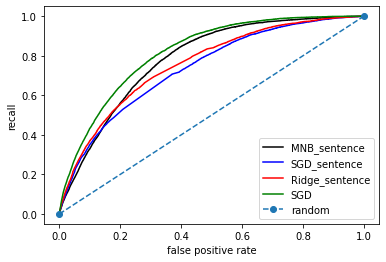

In [197]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print(f"ROC-AUC score for test set = {roc_auc_score(df_stack_test['has_spoiler'], df_stack_test['mnb_sentence_max'])}")
fpr, tpr, threshold = roc_curve(df_stack_train['has_spoiler'], df_stack_train['mnb_sentence_max'])
fpr2, tpr2, threshold2 = roc_curve(df_stack_train['has_spoiler'], df_stack_train['SGD_sentence_max'])
fpr3, tpr3, threshold3 = roc_curve(df_stack_train['has_spoiler'], df_stack_train['Ridge_sentence_max'])
fpr4, tpr4, threshold4 = roc_curve(df_stack_train['has_spoiler'], df_stack_train['SGD_review'])


print(len(fpr))
print(len(tpr))
plt.plot(fpr, tpr, c = 'black', label = 'MNB_sentence')
plt.plot(fpr2, tpr2, c = 'blue', label = 'SGD_sentence')
plt.plot(fpr3, tpr3, c = 'red', label = 'Ridge_sentence')
plt.plot(fpr4, tpr4, c = 'green', label = 'SGD')
plt.plot([0,1], [0,1],'o--', label = 'random')
plt.legend()


plt.xlabel('false positive rate')
plt.ylabel('recall')


In [198]:
# use plotly to also get threshold values while hovering
import plotly.express as px
fig = px.line(x = fpr4, y = tpr4,hover_name = threshold4)
fig.update_layout(
    title="ROC-SGD review wise classification",
    xaxis_title="false positive rate",
    yaxis_title="recall")
fig.show()

In [172]:
# for MNB sentence-wise classification 
# prediction for whole reviews using max sentence score
print(classification_report(df_stack_test['has_spoiler'], np.where(df_stack_test['mnb_sentence_max']>0.5,1,0)))

              precision    recall  f1-score   support

       False       0.99      0.55      0.70    119203
        True       0.12      0.89      0.21      8389

    accuracy                           0.57    127592
   macro avg       0.55      0.72      0.46    127592
weighted avg       0.93      0.57      0.67    127592



In [174]:
# for SGD sentence-wise classification 
# prediction for whole reviews using max sentence score
print(classification_report(df_stack_test['has_spoiler'], np.where(df_stack_test['SGD_sentence_max']>0,1,0)))

              precision    recall  f1-score   support

       False       0.99      0.23      0.38    119203
        True       0.08      0.96      0.15      8389

    accuracy                           0.28    127592
   macro avg       0.53      0.60      0.26    127592
weighted avg       0.93      0.28      0.36    127592



In [175]:
# for Ridge sentence-wise classification 
# prediction for whole reviews using max sentence score
print(classification_report(df_stack_test['has_spoiler'], np.where(df_stack_test['Ridge_sentence_max']>0,1,0)))

              precision    recall  f1-score   support

       False       0.99      0.24      0.39    119203
        True       0.08      0.96      0.15      8389

    accuracy                           0.29    127592
   macro avg       0.54      0.60      0.27    127592
weighted avg       0.93      0.29      0.37    127592



In [176]:
# for SGD review-wise classification 
print(classification_report(df_stack_test['has_spoiler'], np.where(df_stack_test['SGD_review']>0,1,0)))

              precision    recall  f1-score   support

       False       0.99      0.60      0.75    119203
        True       0.13      0.87      0.23      8389

    accuracy                           0.62    127592
   macro avg       0.56      0.74      0.49    127592
weighted avg       0.93      0.62      0.71    127592



The strategy to use a sentence-wise training on only those reviews which contain a spoiler technically worked. Espacially the MNB classifier trained an sentences that have been vectorized using countvectorizer results in a overall accuracy and recall similar to the values observed with Julias SGD model trained on the whole review text. 

In [193]:
# will using a majority vote of teh 4 classifier improve the result?
mnb_p = np.where(df_stack_test['SGD_sentence_max']>0,1,0)
SGD_s_p = np.where(df_stack_test['SGD_sentence_max']>0,1,0)
Ridge_s_p = np.where(df_stack_test['Ridge_sentence_max']>0,1,0)
SGD_r_p = np.where(df_stack_test['SGD_review']>0,1,0)

sum_clfs = mnb_p + SGD_s_p + Ridge_s_p + SGD_r_p
sum_clfs_average = sum_clfs/4
np.unique(sum_clfs, return_counts = True)

(array([0, 1, 2, 3, 4]), array([22588,  4850,  4659, 44015, 51480]))

In [196]:
# append dta to df_stack_train
df_stack_train['sum_pred_spoiler'] = sum_clfs
df_stack_train['spoiler_pred_ratio'] = sum_clfs_average

In [199]:
fpr, tpr, threshold = roc_curve(df_stack_train['has_spoiler'], df_stack_train['spoiler_pred_ratio'])
fig = px.line(x = fpr, y = tpr,hover_name = threshold)
fig.update_layout(
    title="ROC-SGD review wise classification",
    xaxis_title="false positive rate",
    yaxis_title="recall")
fig.show()

In [203]:
# only consier spoiler when predicted by all 4 classifiers
df_stack_train['spoiler_all'] = np.where(df_stack_train['sum_pred_spoiler']==4,1,0)

In [204]:
print(classification_report(df_stack_train['has_spoiler'], df_stack_train['spoiler_all']))

              precision    recall  f1-score   support

       False       0.98      0.63      0.77    119203
        True       0.14      0.85      0.24      8389

    accuracy                           0.64    127592
   macro avg       0.56      0.74      0.50    127592
weighted avg       0.93      0.64      0.73    127592



#### Try a 'stacking' approach using the predicted probabilities/decission function values of the four classifiers

In [182]:
X=df_stack_train.iloc[:,1:5]
X.describe()

,mnb_sentence_max,SGD_sentence_max,Ridge_sentence_max,SGD_review
count,1.275920e+05,127592.000000,127592.000000,127592.000000
mean,5.103738e-01,0.466781,0.189884,-0.096850
std,3.182685e-01,0.946447,0.370459,0.901808
min,3.013273e-34,-13.061287,-4.911244,-3.543471
25%,2.527976e-01,0.133637,0.035721,-0.758790
50%,4.779698e-01,0.880821,0.282053,-0.168657
75%,8.183059e-01,1.000027,0.367804,0.495367
max,1.000000e+00,6.269026,4.027447,5.425183


In [79]:
test_clfs(models_meta, X, df_stack_train['has_spoiler'], cv = 3)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done with SGD


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Done with LinearSVC
Done with LogReg


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py", line 641, in fit
    self._count(X, Y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py", line 763, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1046, in check_non_negative
    raise ValueError("Negative values in data passed to %s" % whom)
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this trai

Done with MultinomialNB


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done with Ridge
Done with D_Tree_CLF
Done with Random_forrest
Done with GradientBoostingClassifier
Done with Bagging_LR
Done with Bagging_Tree
Done with Adaboost_Tree


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,SGDClassifier(),0.661 +/- 0.013,0.935 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.78 +/- 0.057,0.483 +/- 0.0
1,LinearSVC(random_state=42),86.088 +/- 0.442,0.935 +/- 0.0,0.003 +/- 0.0,0.726 +/- 0.001,0.834 +/- 0.0,0.486 +/- 0.0
2,"LogisticRegression(n_jobs=-1, random_state=42)",2.084 +/- 0.505,0.934 +/- 0.0,0.043 +/- 0.001,0.487 +/- 0.008,0.834 +/- 0.001,0.522 +/- 0.001
3,MultinomialNB(alpha=1e-06),0.076 +/- 0.002,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan,nan +/- nan
4,RidgeClassifier(random_state=42),0.17 +/- 0.017,0.935 +/- 0.0,0.0 +/- 0.0,0.467 +/- 0.411,0.833 +/- 0.0,0.483 +/- 0.0
5,DecisionTreeClassifier(random_state=42),6.031 +/- 0.069,0.889 +/- 0.0,0.192 +/- 0.003,0.179 +/- 0.002,0.565 +/- 0.001,0.563 +/- 0.001
6,RandomForestClassifier(),235.248 +/- 15.939,0.933 +/- 0.0,0.046 +/- 0.001,0.387 +/- 0.005,0.798 +/- 0.0,0.524 +/- 0.001
7,GradientBoostingClassifier(),106.996 +/- 8.856,0.935 +/- 0.0,0.019 +/- 0.0,0.603 +/- 0.004,0.837 +/- 0.0,0.502 +/- 0.0
8,BaggingClassifier(base_estimator=LogisticRegre...,15.828 +/- 0.41,0.934 +/- 0.0,0.043 +/- 0.001,0.488 +/- 0.009,0.834 +/- 0.0,0.522 +/- 0.001
9,BaggingClassifier(base_estimator=DecisionTreeC...,38.571 +/- 2.269,0.933 +/- 0.0,0.046 +/- 0.001,0.412 +/- 0.004,0.816 +/- 0.001,0.524 +/- 0.001


In [183]:
# also test imblearn balanced bagging classifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier,RUSBoostClassifier

models_imblearn = {}

models_imblearn['BalancedRandomForestClassifier'] = BalancedRandomForestClassifier()
models_imblearn['Bagging-SVC'] = BalancedBaggingClassifier(base_estimator= LinearSVC())
models_imblearn['Bagging-KNN'] = BalancedBaggingClassifier(base_estimator= KNeighborsClassifier())
models_imblearn['Bagging-Logistic'] = BalancedBaggingClassifier(base_estimator= LogisticRegression())
models_imblearn['Bagging-Tree'] = BalancedBaggingClassifier(base_estimator= DecisionTreeClassifier())
models_imblearn['Bagging-Ridge'] = BalancedBaggingClassifier(base_estimator= RidgeClassifier())
models_imblearn['RUSBoost'] = RUSBoostClassifier()

test_clfs(models_imblearn, X, df_stack_train['has_spoiler'], cv = 3)

ERROR! Session/line number was not unique in database. History logging moved to new session 437
Done with BalancedRandomForestClassifier


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:

Done with Bagging-SVC
Done with Bagging-KNN
Done with Bagging-Logistic
Done with Bagging-Tree
Done with Bagging-Ridge
Done with RUSBoost


,classifier,fit_time,accuracy,recall,precision,roc_auc,f1_macro
0,BalancedRandomForestClassifier(),6.942 +/- 0.242,0.689 +/- 0.002,0.792 +/- 0.003,0.149 +/- 0.001,0.811 +/- 0.002,0.527 +/- 0.001
1,BalancedBaggingClassifier(base_estimator=Linea...,5.536 +/- 0.346,0.716 +/- 0.002,0.776 +/- 0.006,0.16 +/- 0.001,0.823 +/- 0.001,0.544 +/- 0.002
2,BalancedBaggingClassifier(base_estimator=KNeig...,0.438 +/- 0.076,0.697 +/- 0.002,0.762 +/- 0.004,0.149 +/- 0.001,0.8 +/- 0.002,0.53 +/- 0.002
3,BalancedBaggingClassifier(base_estimator=Logis...,0.802 +/- 0.145,0.724 +/- 0.003,0.769 +/- 0.005,0.162 +/- 0.001,0.824 +/- 0.001,0.549 +/- 0.002
4,BalancedBaggingClassifier(base_estimator=Decis...,1.019 +/- 0.083,0.788 +/- 0.0,0.571 +/- 0.005,0.17 +/- 0.001,0.781 +/- 0.001,0.569 +/- 0.001
5,BalancedBaggingClassifier(base_estimator=Ridge...,0.532 +/- 0.047,0.711 +/- 0.003,0.782 +/- 0.006,0.158 +/- 0.002,0.823 +/- 0.001,0.541 +/- 0.002
6,RUSBoostClassifier(),2.385 +/- 0.183,0.677 +/- 0.013,0.821 +/- 0.016,0.148 +/- 0.003,0.819 +/- 0.002,0.522 +/- 0.007


In [185]:
# test RUSBoostClassifier on test data
RUSBoostCLF = RUSBoostClassifier()
RUSBoostCLF.fit(X, df_stack_train['has_spoiler'])

RUSBoostClassifier()

In [186]:
# predict test data
X_test = df_stack_test.iloc[:,1:5]
prediction_stack_test = RUSBoostCLF.predict(X_test)

In [187]:
# classification report on test data
print(classification_report(df_stack_test['has_spoiler'],prediction_stack_test ))

              precision    recall  f1-score   support

       False       0.98      0.65      0.78    119203
        True       0.14      0.84      0.24      8389

    accuracy                           0.66    127592
   macro avg       0.56      0.74      0.51    127592
weighted avg       0.93      0.66      0.74    127592



It looks like we won't get better than that. We consider a recall of 0.85 as satisfactory, but all models suffer from a low precission/high fals positive rate. 